In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import random
import matplotlib.pyplot as plt
import PIL
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from IPython.display import display
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler 
from random import sample

In [2]:
train = {}
test = {}

path = r"C:\Users\David\Documents\DSC 680\Project 3 Food"

path_train = os.path.join(path, "training")
for i in os.listdir(path_train):
    train[i] = os.listdir(os.path.join(path_train, i))

path_test = os.path.join(path, "validation")
for i in os.listdir(path_test):
    test[i] = os.listdir(os.path.join(path_test, i))

In [25]:
print("Number of images in training data : {}".format(np.concatenate(list(train.values())).shape[0]))
print("Number of images in testing data : {}".format(np.concatenate(list(test.values())).shape[0]))

Number of images in training data : 9866
Number of images in testing data : 3430


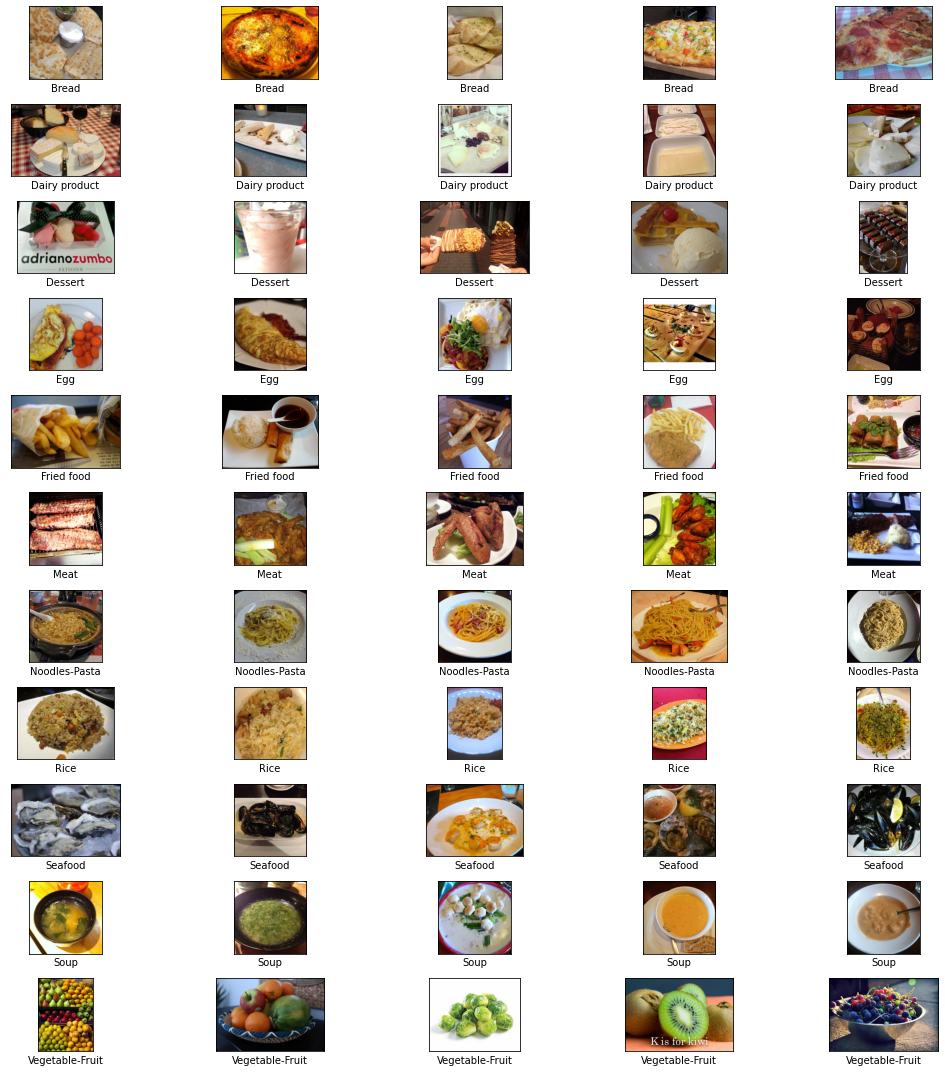

In [4]:
fig, axs = plt.subplots(len(train.keys()), 5, figsize = (15, 15))
for i, item in enumerate(os.listdir(path_train)):
    images = sample(train[item], 5)
    
    for j, image in enumerate(images):
        img = PIL.Image.open(os.path.join(path_train, item, image))
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel = item, xticks = [], yticks = [])

fig.tight_layout()

In [5]:
for item in train.keys():
    print(item, len(train[item]))

Bread 994
Dairy product 429
Dessert 1500
Egg 986
Fried food 848
Meat 1325
Noodles-Pasta 440
Rice 280
Seafood 855
Soup 1500
Vegetable-Fruit 709


C:\Users\David\anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


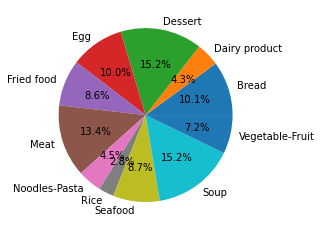

In [33]:
fig, ax = plt.subplots()
ax.pie(
    [len(train[item]) for item in train],
    labels = train.keys(),
    autopct = "%1.1f%%"
)
fig.show()

In [7]:
train_rescale = ImageDataGenerator(
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    rescale=1./255
)


test_data = ImageDataGenerator(rescale=1./255)

In [8]:
train_gen = train_rescale.flow_from_directory(
    path_train,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)


test_gen = test_data.flow_from_directory(
    path_test,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

Found 9866 images belonging to 11 classes.
Found 3430 images belonging to 11 classes.


In [9]:
basemodel = InceptionResNetV2(
    weights = "imagenet",
    include_top = False, 
    input_tensor = Input((256, 256, 3))
)

In [10]:
basemodel.trainable = False

In [11]:
# Add classification head to the model
model_setup = basemodel.output
model_setup = GlobalAveragePooling2D(name = "Global_Average_Pool")(model_setup)
model_setup = Flatten(name = "flatten")(model_setup)
model_setup = Dense(256, activation = "relu", name = "dense_1")(model_setup)
model_setup = Dropout(0.3)(model_setup)
model_setup = Dense(128, activation = "relu", name = "dense_2")(model_setup)
model_setup = Dropout(0.3)(model_setup)
model_setup = Dense(11, activation = "softmax", name = "output")(model_setup)

model = Model(inputs = basemodel.input, outputs = model_setup)

In [12]:
model.compile(
    loss = "categorical_crossentropy",
    optimizer = SGD(
        lr = 0.01,
        momentum = 0.9
    ),
    metrics = ["accuracy"]
)

In [13]:
earlystopping = EarlyStopping(
    monitor = 'loss', 
    verbose = 1, 
    patience = 20
)


checkpointer = ModelCheckpoint(
    filepath = "weights.hdf5", 
    verbose = 1, 
    save_best_only = True
)

In [14]:
run_model = model.fit(
    train_gen, 
    steps_per_epoch = train_gen.n // 32, 
    epochs = 1,  
    callbacks = [checkpointer, earlystopping]
)

  ...
    to  
  ['...']
Train for 308 steps
308/308 [==============================] - 5311s 17s/step - loss: 1.6354 - accuracy: 0.4470


In [15]:
basemodel.trainable = True

In [16]:
earlystopping = EarlyStopping(
    monitor = 'loss', 
    verbose = 1, 
    patience = 20
)

checkpointer = ModelCheckpoint(
    filepath = "weights_fine.hdf5", 
    verbose = 1, 
    save_best_only = True
)

In [17]:
run_model = model.fit(
    train_gen, 
    steps_per_epoch = train_gen.n // 32, 
    epochs = 5, 
    callbacks = [checkpointer, earlystopping]
)

  ...
    to  
  ['...']
Train for 308 steps
Epoch 1/5
308/308 [==============================] - 5832s 19s/step - loss: 1.2123 - accuracy: 0.6026
Epoch 2/5
308/308 [==============================] - 4923s 16s/step - loss: 1.0904 - accuracy: 0.6443
Epoch 3/5
308/308 [==============================] - 5250s 17s/step - loss: 1.0196 - accuracy: 0.6675
Epoch 4/5
308/308 [==============================] - 4474s 15s/step - loss: 0.9845 - accuracy: 0.6740
Epoch 5/5
308/308 [==============================] - 4218s 14s/step - loss: 0.9423 - accuracy: 0.6935


In [18]:
evaluate = model.evaluate_generator(
    test_gen, 
    steps = test_gen.n // 32, 
    verbose = 1
)

print('Accuracy Test : {}'.format(evaluate[1]))

Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']
107/107 [==============================] - 775s 7s/step - loss: 1.0571 - accuracy: 0.7261
Accuracy Test : 0.726051390171051


In [19]:
labels = {
    0: 'Bread', 
    1: 'Dairy product', 
    2: 'Dessert', 
    3: 'Egg', 
    4: 'Fried food', 
    5: 'Meat',
    6: 'Noodles-Pasta',
    7: 'Rice', 
    8: 'Seafood',
    9: 'Soup',
    10: 'Vegetable-Fruit'
}

In [21]:
prediction = []
original = []
image = []
count = 0
path_eval = r"C:\Users\David\Documents\DSC 680\Project 3 Food\evaluation"
for i in os.listdir(path_eval):
    for item in os.listdir(os.path.join(path_eval, i)):
        img= PIL.Image.open(os.path.join(path_eval, i, item))
        img = img.resize((256,256))
        image.append(img)
        img = np.asarray(img, dtype= np.float32)
        img = img / 255
        img = img.reshape(-1,256,256,3)
        predict = model.predict(img)
        predict = np.argmax(predict)
        prediction.append(labels[predict])
        original.append(i)

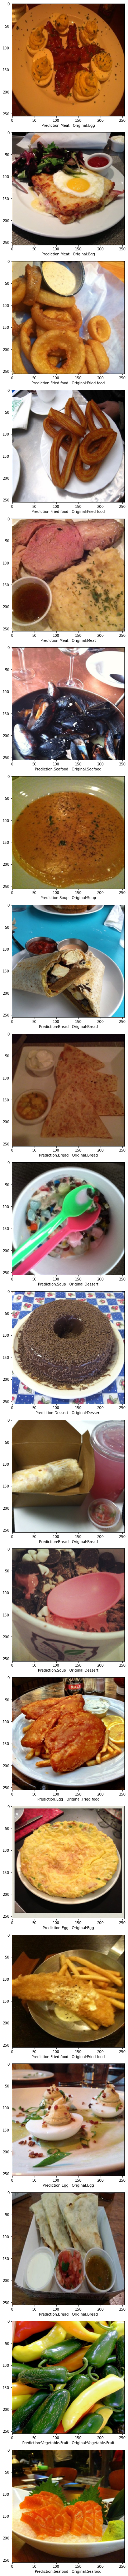

In [34]:
fig=plt.figure(figsize = (100,100))
for i in range(20):
    j = random.randint(0,len(image))
    fig.add_subplot(20,1,i+1)
    plt.xlabel("Prediction:" + prediction[j] +"   Original:" + original[j])
    plt.imshow(image[j])
fig.tight_layout()
plt.show()

In [23]:
print(classification_report(np.asarray(prediction), np.asarray(original)))

                 precision    recall  f1-score   support

          Bread       0.69      0.76      0.72       336
  Dairy product       0.42      0.83      0.56        75
        Dessert       0.52      0.89      0.66       290
            Egg       0.82      0.43      0.56       635
     Fried food       0.61      0.84      0.70       207
           Meat       0.90      0.66      0.76       590
  Noodles-Pasta       0.99      0.82      0.90       177
           Rice       0.94      0.91      0.92        99
        Seafood       0.56      0.83      0.67       206
           Soup       0.97      0.89      0.93       544
Vegetable-Fruit       0.78      0.96      0.86       188

       accuracy                           0.74      3347
      macro avg       0.74      0.80      0.75      3347
   weighted avg       0.79      0.74      0.74      3347



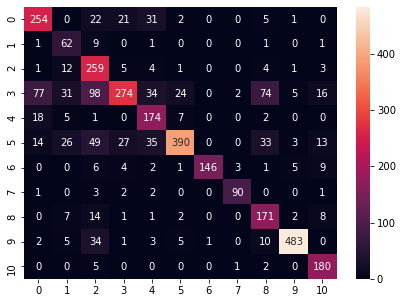

In [24]:
plt.figure(figsize = (7, 5))
cm = confusion_matrix(np.asarray(prediction), np.asarray(original))
sns.heatmap(
    cm, 
    annot = True, 
    fmt = "d"
)
plt.show()